# Motion Detection Notebook
- the purpose of this notebook is to detect motion in recorded video, and to then subsequently save a new version of the video that only includes that motion
- this eliminates all the inactive parts of a recorded video and allows one to then, for example, do object detection on only the relevant subset where action is occuring

## Frame Manipulation Overview
The detection script works by taking the difference in pixel values between two subsequent video frames and seeing how many pixels are significantly different between the two. If this difference exceeds some threshold, this is counted as "motion". If enough successive frames are deemed to have motion, we count this as verification of movement in the video and record these frames to a separate "active" video file.

In order to best calculate the difference between two frames, each frame is manipulated in three ways:
1. the frame is converted to greyscale, so that each pixel only has one value. If it was RGB, there'd be three values to compare in each pixel.
2. the frame is shrunk, by pooling blocks of pixels into an average. So for a 10x10 grid of pixels, their average is taken and this is the new value. This eliminates small single-pixel variations in each frmae and thus encourages detection of larger macro movements in the video.
3. any areas of the frame deemed to be irrelevant to the motion detection are excluded. These include things like bushes in the foreground that might move around in the wind but shouldn't be considered as "active" motion.

Once the two frames are subtracted from one another, we perform one more operation:
1. we convert the pixels of the differenced image to 0's and 1's, where any 1's represent pixels beyond some absolute difference threshold.


### Example Difference Manipulation:

In [2]:
import imageio
from PIL import Image
from matplotlib import pyplot as plt
import skimage.measure
import numpy as np

In [3]:
%matplotlib inline

In [5]:
# read in the video using imageio's get_reader
video = imageio.get_reader('video_files/111818_00_unedited.MOV')

In [35]:
example_frame_1 = Image.fromarray(video.get_data(11415))
example_frame_2 = Image.fromarray(video.get_data(11430))

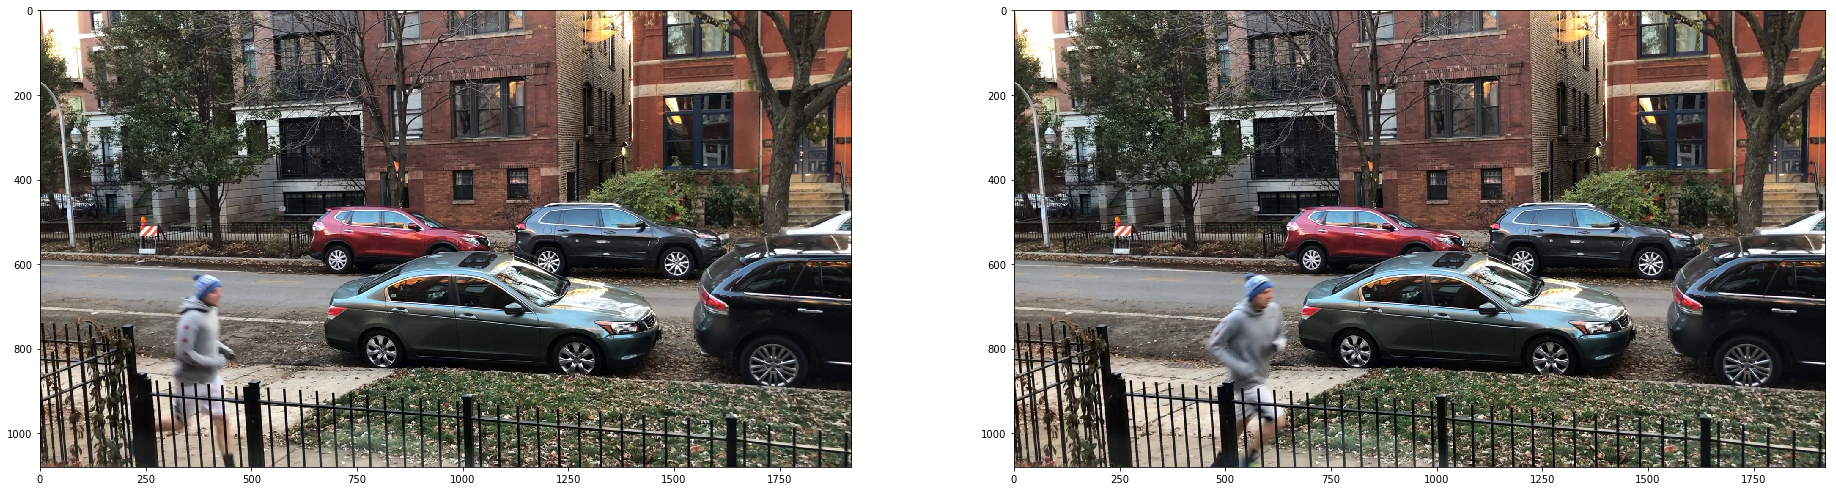

In [7]:
# original unaltered frames
f = plt.figure(figsize=(32,32))
f.add_subplot(1,2,1)
plt.imshow(example_frame_1)
f.add_subplot(1,2,2)
plt.imshow(example_frame_2)
plt.show();

In [40]:
# convert the frames to greyscale
example_frame_1 = example_frame_1.convert(mode='L')
example_frame_2 = example_frame_2.convert(mode='L')

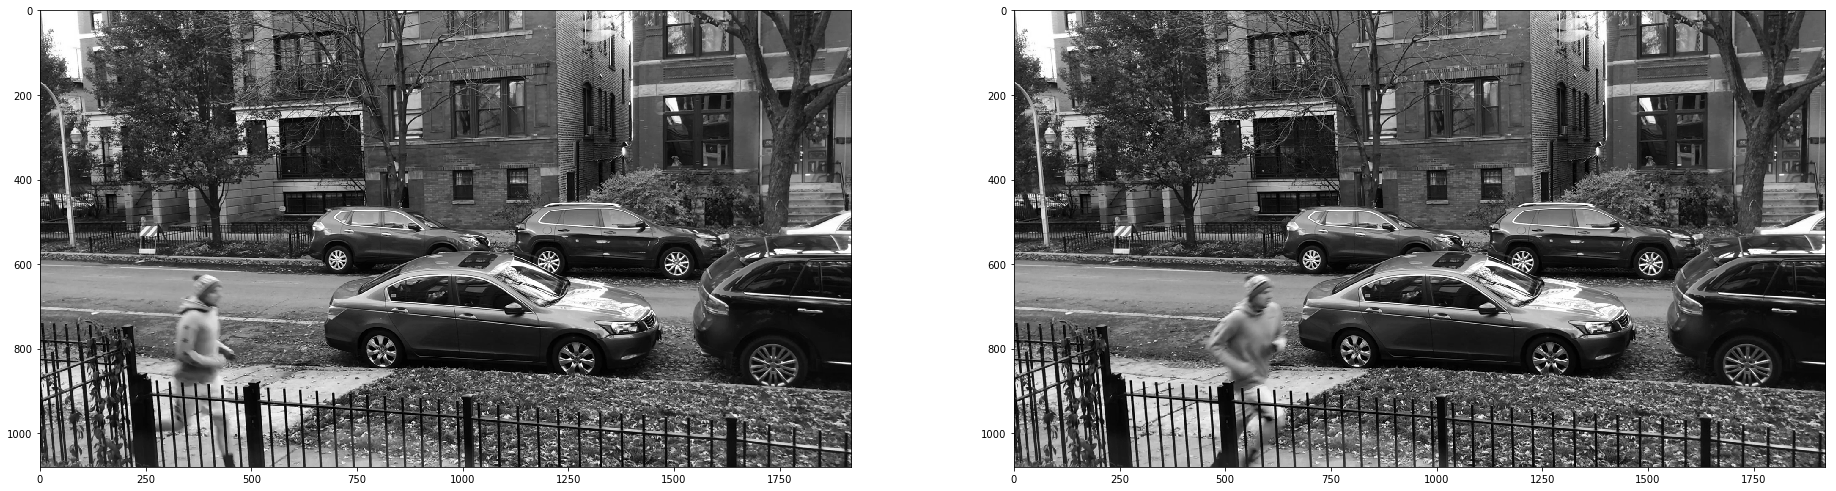

In [9]:
# greyscale frames
f = plt.figure(figsize=(32,32))
f.add_subplot(1,2,1)
plt.imshow(example_frame_1, cmap='gray')
f.add_subplot(1,2,2)
plt.imshow(example_frame_2, cmap='gray')
plt.show();

In [10]:
POOL_SIZE = (10,10)

In [43]:
# pool the frames based on a (say 10x10) grid average
example_frame_1 = skimage.measure.block_reduce(np.asarray(example_frame_1), POOL_SIZE, np.mean)
example_frame_2 = skimage.measure.block_reduce(np.asarray(example_frame_2), POOL_SIZE, np.mean)

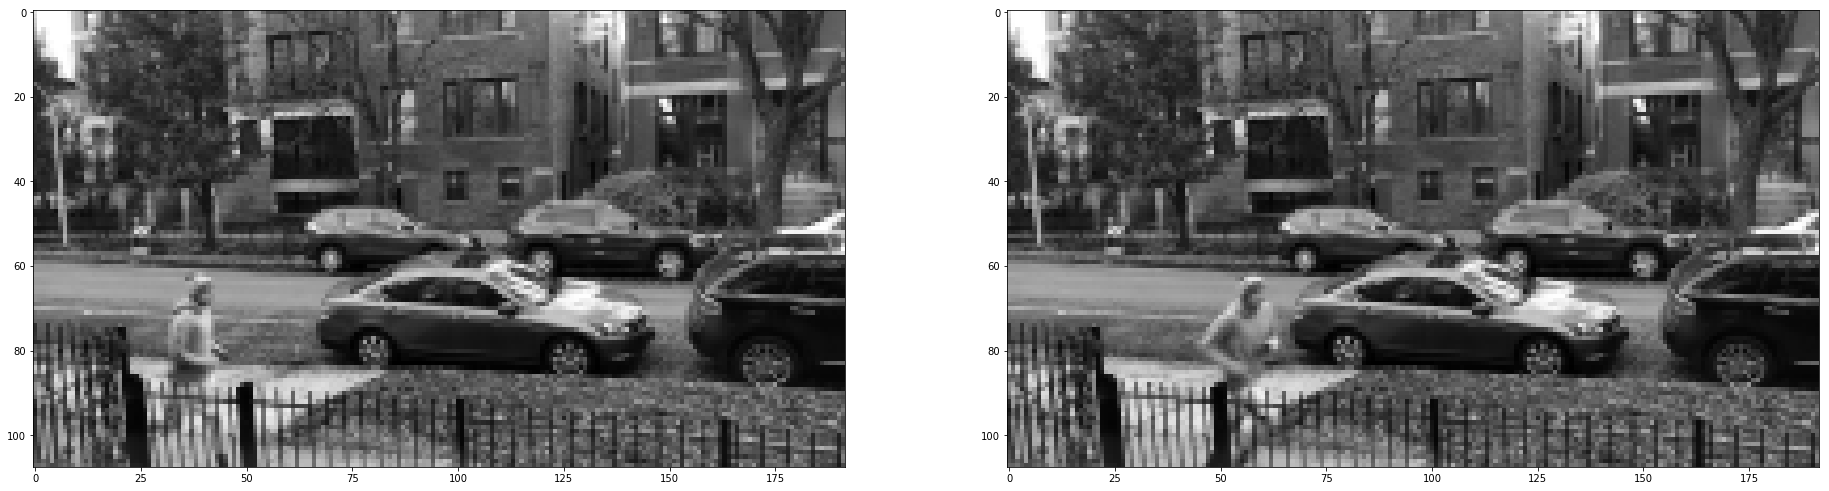

In [44]:
# pooled greyscale frames
f = plt.figure(figsize=(32,32))
f.add_subplot(1,2,1)
plt.imshow(example_frame_1, cmap='gray')
f.add_subplot(1,2,2)
plt.imshow(example_frame_2, cmap='gray')
plt.show();

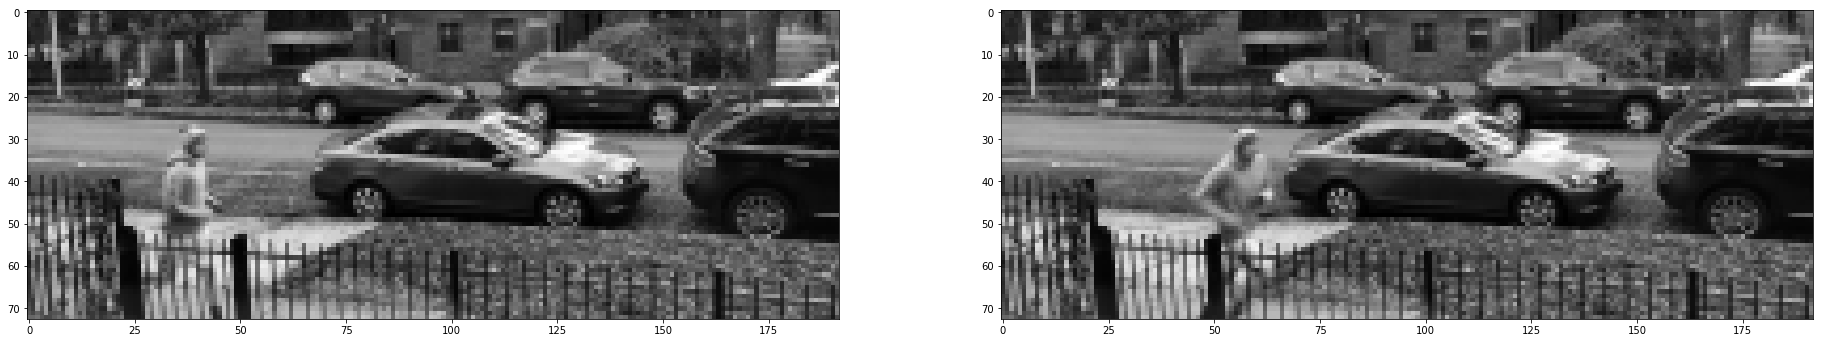

In [45]:
# if we want to ignore some part of the frame, which part?
IGNORE_ROWS = 35

f = plt.figure(figsize=(32,32))
f.add_subplot(1,2,1)
plt.imshow(example_frame_1[IGNORE_ROWS:], cmap='gray')
f.add_subplot(1,2,2)
plt.imshow(example_frame_2[IGNORE_ROWS:], cmap='gray')
plt.show();

In [46]:
# get the difference between the two frames
example_frame_diff = example_frame_1[IGNORE_ROWS:] - example_frame_2[IGNORE_ROWS:]

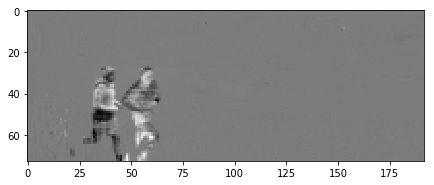

In [57]:
# the difference frame
plt.figure(figsize=(7.1111, 4))
plt.imshow(example_frame_diff, cmap='gray');

In [59]:
# convert any large differences to the value 1, all others to 0
# might not be a necessary step, consider removing, but at least simplifies future steps by only having 0's and 1's
# the difference threshold is adjustable and should be explored for best results
DIFF_THRESHOLD = 20

example_frame_diff[(example_frame_diff <  DIFF_THRESHOLD) & (example_frame_diff >  -DIFF_THRESHOLD)] = 0
example_frame_diff[(example_frame_diff >= DIFF_THRESHOLD) | (example_frame_diff <= -DIFF_THRESHOLD)] = 1

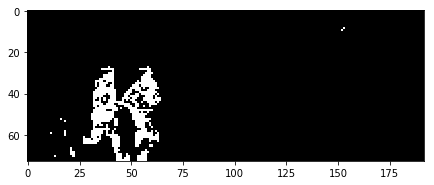

In [60]:
# the difference frame again, now binary
plt.figure(figsize=(7.1111, 4))
plt.imshow(example_frame_diff, cmap='gray');

In [33]:
print(example_frame_diff.shape) # shape of the pooled difference frame
total_pixels_whole_frame = example_frame_diff.shape[0] * example_frame_diff.shape[1]
print(total_pixels_whole_frame)
total_pixels_with_movement = example_frame_diff[example_frame_diff == 1].shape[0]
print(total_pixels_with_movement)
print(total_pixels_with_movement / total_pixels_whole_frame) # percentage of the frame with movement

(73, 192)
14016
683
0.048730022831050226


# Motion Detection Script (Jupyter Version)
- this actually goes through a video and saves the frames with motion

In [19]:
import datetime
# import imageio
# import numpy as np
# from PIL import Image
# import skimage.measure

In [20]:
# FIXED_VARIABLES
FRAME_GAP = 15                                 # gap between frames to be differenced
                                               # can change depending on FPS, for example 15 FPS & FRAME_GAP=15 is a 1.0 second lag
POOL_SIZE = (10,10)                            # length & width of pixels to be average pooled together
DIFF_THRESHOLD = 20                            # absolute value required between two pixels to be counted as "motion"
TOTAL_DIFF_PIX_REQUIRED = 18                   # number of total pix in frame required to be different before frame considered "active"
CONSECUTIVE_NUM_ACTIVE_FRAMES_REQUIRED = 15    # number of consecutive active frames needed before we consider it official motion
CONSECUTIVE_NUM_INACTIVE_FRAMES_REQUIRED = 45  # number of consecutive inactive frames needed before we consider the motion to be over

In [6]:
video_file_name = '111818_00_unedited.MOV'

In [7]:
sys_path_to_video = 'video_files/'

In [8]:
# read in the video using imageio's get_reader
video = imageio.get_reader(sys_path_to_video + video_file_name)

In [25]:
# let's get some relevant stats about the video
fps_video = video.get_meta_data()['fps']
print('Video FPS:', fps_video)
tot_num_frames_video = video.get_meta_data()['nframes']
print('Total Number of Frames in Video:', tot_num_frames_video)

Video FPS: 60.0
Total Number of Frames in Video: 23522


In [26]:
# create the video writer object where we'll save any relevant frames.
# the macro_block_size doesn't really matter, but must be able to divide into the dimensions of the video or
# else some small portion of the video will be cropped
video_writer = imageio.get_writer(sys_path_to_video + 'motion_only_' + video_file_name, fps=fps_video, macro_block_size=8)

### Big Script That Actually Does the Work:

In [28]:
count_activity   = 0 # each time a consecutive frame is deemed to have motion, counter goes up
count_inactivity = 0 # each time a consecutive frame is deemed to not have motion, counter goes up
start_frame      = 0 # starting frame to record to new motion_dection video clip
end_frame        = 0 # ending frame to record to new motion_dection video clip

start_time = datetime.datetime.now() # track the time, this code sometimes takes a while

try:
    for i in range(0, tot_num_frames_video - FRAME_GAP - 1): # iterate through every frame in video
        
        # get our two comparison frames
        frame_1 = Image.fromarray(video.get_data(i))
        frame_2 = Image.fromarray(video.get_data(i + FRAME_GAP))
        
        # convert the frames to greyscale
        frame_1 = frame_1.convert(mode='L')
        frame_2 = frame_2.convert(mode='L')
        
        # average pool the frames to eliminate small variations in single pixels
        frame_1 = skimage.measure.block_reduce(np.asarray(frame_1), POOL_SIZE, np.mean)
        frame_2 = skimage.measure.block_reduce(np.asarray(frame_2), POOL_SIZE, np.mean)
        
        # get the difference
        frame_diff = frame_1 - frame_2
        # frame_diff = frame_diff[35:] # used if we don't want to consider part of the frame for motion (like trees)
        
        # convert each pixel value to 1 or 0 depending on the absolute value
        frame_diff[(frame_diff <  DIFF_THRESHOLD) & (frame_diff >  -DIFF_THRESHOLD)] = 0
        frame_diff[(frame_diff >= DIFF_THRESHOLD) | (frame_diff <= -DIFF_THRESHOLD)] = 1

        # how many moving pixels are there?
        total_pixels_with_movement = frame_diff[frame_diff == 1].shape[0]

        # increase activity count every time frames exceed difference threshold
        # else increase inactivity count
        if total_pixels_with_movement >= TOTAL_DIFF_PIX_REQUIRED:
            count_activity  += 1
            count_inactivity = 0
            # do we have enough consecutive frames with activity? If so, this marks the beginning of our movement
            if count_activity == CONSECUTIVE_NUM_ACTIVE_FRAMES_REQUIRED and start_frame == 0:
                start_frame = max(1, i - 40) # subtract 40 frames to get a bit of lead time before the activity
        else:
            count_inactivity += 1
            count_activity = 0
            # do we have enough consecutive frames without activity and has there been activity (indicated by start_frame > 0)
            if count_inactivity >= CONSECUTIVE_NUM_INACTIVE_FRAMES_REQUIRED and start_frame > 0:
                count_activity   = 0
                count_inactivity = 0
                end_frame = i       
                # record this activity to the new video
                for j in range(start_frame, end_frame):
                    video_writer.append_data(video.get_data(j))
                print('activity recorded:', start_frame, end_frame)
                # restart everything and continue on
                start_frame = 0
                end_frame   = 0

        if i % 1000 == 0:
            current_time = datetime.datetime.now()
            elapsed_time = current_time - start_time
            print('on frame:', i, 'time taken:', "{:.2f}".format(elapsed_time.seconds / 60), 'minutes')
except:
    video_writer.close()
    
if not video_writer.closed:
    video_writer.close()

on frame: 0 time taken: 0.00 minutes
on frame: 1000 time taken: 8.55 minutes
on frame: 2000 time taken: 17.55 minutes
on frame: 3000 time taken: 25.03 minutes
on frame: 4000 time taken: 32.42 minutes
activity recorded: 2358 4202
on frame: 5000 time taken: 41.68 minutes
activity recorded: 4461 5167
on frame: 6000 time taken: 49.83 minutes
activity recorded: 5522 6330
on frame: 7000 time taken: 58.02 minutes
activity recorded: 6372 7310
activity recorded: 7372 7792
activity recorded: 7820 7920
on frame: 8000 time taken: 66.78 minutes
activity recorded: 8269 8431
on frame: 9000 time taken: 74.22 minutes
on frame: 10000 time taken: 81.48 minutes
activity recorded: 9076 10462
activity recorded: 10574 10664
on frame: 11000 time taken: 90.22 minutes
activity recorded: 11046 11561
on frame: 12000 time taken: 98.03 minutes
activity recorded: 11870 12390
on frame: 13000 time taken: 105.90 minutes
activity recorded: 13201 13518
on frame: 14000 time taken: 113.92 minutes
on frame: 15000 time taken